# Bike Sharing Demand

Forecast use of a city bikeshare system

## Introduction

Bike-sharing systems are present all around the world in many major cities. Its' automated nature allows collecting a big amount of live information about the rental type, time and even location. Based on this data, analysts can predict the future bike demand across different time, location and conditions.

The following dataset has been collected and published by 'Capital Bikeshare' program in Washington, D.C. in the US.

The dataset contains hourly rental data spanning two years regarding public bicycles usage. The training set contains data covering a period from 1st of each month to 19th, whereas test set covers the rest of the month.

In the following kernel, we will do explanatory data analysis to find the common patterns and behaviour of customers. In the later parts, we will also try to predict the total count of bikes rented during each hour covered in the test set using machine learning models and test it in the Kaggle submission platform.

## Kernel setup

In [54]:
%load_ext autoreload
%autoreload 2


from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
import warnings

sns.set(rc={'figure.figsize': (16.5, 8.27)})
warnings.filterwarnings("ignore", category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

In [2]:
DATASET_LOCATION = './dataset'

train_set = pd.read_csv(f'{DATASET_LOCATION}/train.csv', keep_default_na=True)
test_set = pd.read_csv(f'{DATASET_LOCATION}/test.csv', keep_default_na=True)

In [3]:
train_set.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


Although most columns are self-explanatory, some might be a bit more mysterious.

|   Column   |                   Description                   |
|:----------:|:-----------------------------------------------:|
|  datetime  |                 Date + Timestamp                |
|   season   |                  Current season                 |
|   holiday  |    Indicator whether current date is holiday    |
| workingday |  Indicator whether current date is working date |
|   weather  |                 Current weather                 |
|    temp    |              Temperature in Celcius             |
|    atemp   |       "Feels like" temperature in Celsius       |
|  humidity  |        Relative humidity (Measured in %)        |
|  windspeed |           Windspeed (Measured in km/h)          |
|   casual   | Number of non-registered user rentals initiated |
| registered |   Number of registered user rentals initiated   |
|    count   |             Number of total rentals             |

Also, few columns are already converted to numerical values hence needs a bit more clarification.

**Season**

| Category | Description |
|:--------:|:-----------:|
|     1    |    Spring   |
|     2    |    Summer   |
|     3    |    Autumn   |
|     4    |    Winter   |

**Weather**

| Category |                                       Description                                       |
|:--------:|:---------------------------------------------------------------------------------------:|
|     1    |                     Clear, Few clouds, Partly cloudy, Partly cloudy                     |
|     2    |                  Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist                  |
|     3    | Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds |
|     4    |                Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog               |

It is worth noticing that the DateTime is not a proper ISO-8601 date and will be needed proper conversion.

## Insight

In [4]:
train_set.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [5]:
test_set.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

The dataset is fairly well prepared as there are no missing values. It will make data preparation easier as missing values always bring uncertainty to the prediction model.

In [6]:
train_set.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

As mentioned earlier, DateTime will require the most preprocessing as it is an object value and not a proper ISO-8601 date.

The rest of the columns are straightforward - **temp**, **atemp** and **windspeed** are floating decimals whereas the rest of the columns contain just integers.

In [7]:
train_set.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


The **temp** varies from 0.82C to 41C. **atemp** broadens this range from 0.76C to 45.45C.

The **windspeed** varies from 0 to nearly 57 km/h.

The **humidity** varies from 0 to 100%.

During the last two years the average whether rather clear/moderately cloudy.

## Exploratory Data Analysis

In [4]:
train_set_dt = train_set.copy()
train_set_dt['datetime-iso8601'] = pd.to_datetime(train_set['datetime'])
train_set_dt = train_set_dt.drop(columns=['datetime'])

### Season

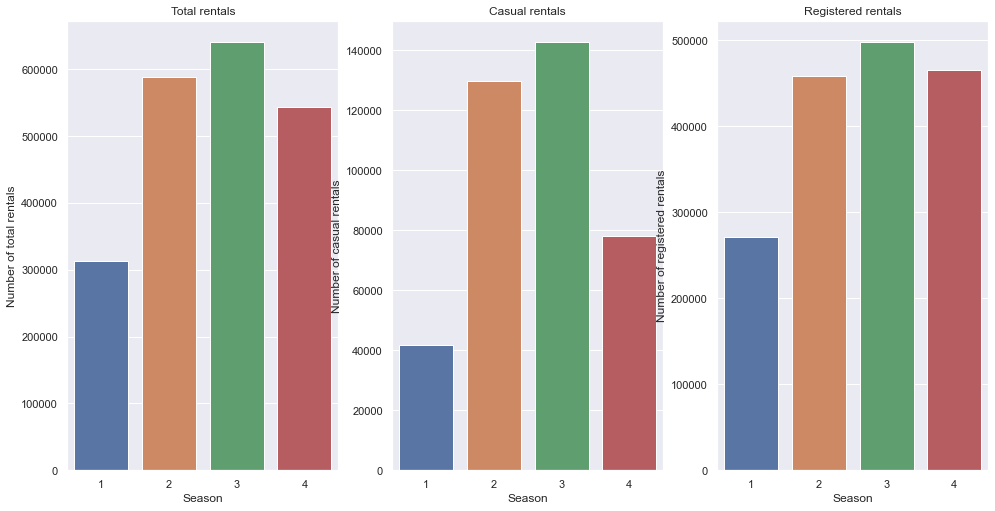

In [9]:
f, axes = plt.subplots(1, 3)

# Total rentals
total_rentals = train_set_dt[['season', 'count']].groupby('season').sum().reset_index()
season_count = sns.barplot('season', 'count', data=total_rentals, ax=axes[0])
season_count.set(xlabel='Season', ylabel='Number of total rentals', title='Total rentals')

# Casual rentals
casual_rentals = train_set_dt[['season', 'casual']].groupby('season').sum().reset_index()
season_casual = sns.barplot('season', 'casual', data=casual_rentals, ax=axes[1])
season_casual.set(xlabel='Season', ylabel='Number of casual rentals', title='Casual rentals')

# Casual rentals
registered_rentals = train_set_dt[['season', 'registered']].groupby('season').sum().reset_index()
season_registered = sns.barplot('season', 'registered', data=registered_rentals, ax=axes[2])
season_registered.set(xlabel='Season', ylabel='Number of registered rentals', title='Registered rentals');

The most popular season for bike-sharing is always the Fall - with more than 600.000 records, followed by summer (around 580.000 rentals). Surprisingly, winter is always a more popular season than spring. During that season time, people still rent nearly twice as much as during springtime.

A total, casual and registered number of rentals during all seasons are very closely correlated (nearly linear). Interestingly, only during wintertime number of registered rentals is higher than during summer.

### Temperature

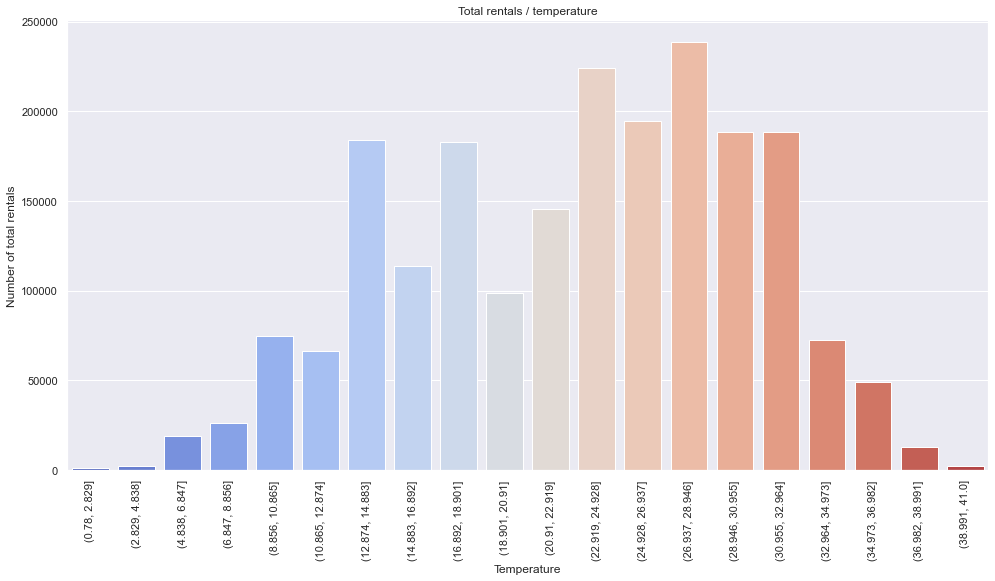

In [10]:
train_set_dt['binned_temp'] = pd.cut(train_set_dt['temp'], 20)
binned_temp_count = train_set_dt[['binned_temp', 'count']].groupby('binned_temp').sum().reset_index()
temp_count = sns.barplot('binned_temp', 'count', data=binned_temp_count, palette='coolwarm')
temp_count.set(xlabel='Temperature', ylabel='Number of total rentals', title='Total rentals / temperature');
temp_count.set_xticklabels(temp_count.get_xticklabels(), rotation=90);

It should not come as a surprise that the warm temperature between 23C - 30C is the most lucrative for bike-sharing companies. Nonthiswising, this collides with the previous prediction that winter is a more popular season for bike-sharing than spring. If we assume that during the winter the temperature range is between 0C and 10C whereas spring temperature could range from 10 to 19 then the spring should bring more customers than winter!

There might be few reasons for this anomaly, the season categories could be wrongly described in the provided dataset or those could mean something different (i.e. company is located in a different location than the dataset was taken).

### Holiday

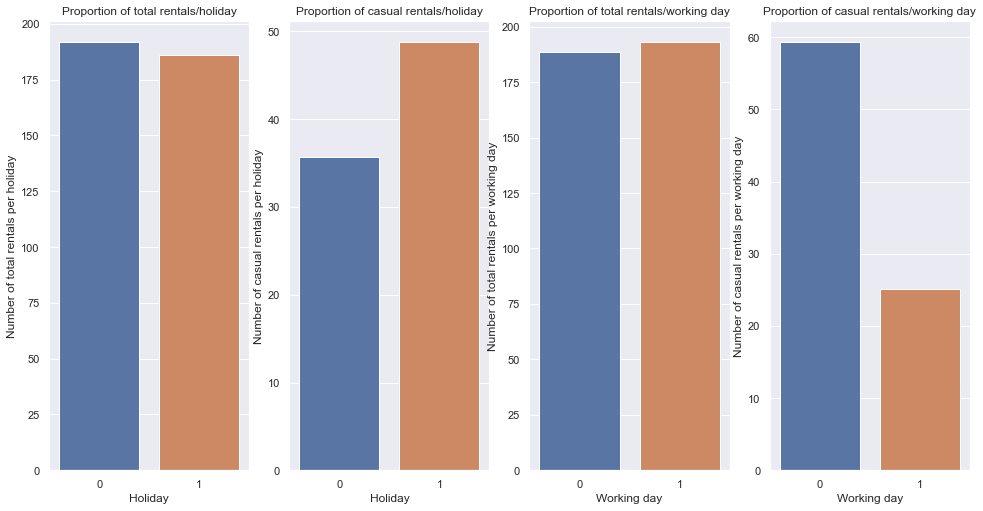

In [11]:
def get_proportion_of_cols(col_1, col_2):
    num_of_hols = train_set_dt.groupby([col_1])[col_1].count()
    return train_set_dt[[col_1, col_2]].groupby(col_1).sum().apply(lambda g: g / num_of_hols).reset_index()


f_2, axes_2 = plt.subplots(1, 4)

# Holiday
# Count
total_per_holiday = get_proportion_of_cols('holiday', 'count')
holiday_count = sns.barplot('holiday', 'count', data=total_per_holiday, ax=axes_2[0])
holiday_count.set(xlabel='Holiday', ylabel='Number of total rentals per holiday',
                  title='Proportion of total rentals/holiday')

# Casual
casual_per_holiday = get_proportion_of_cols('holiday', 'casual')
holiday_casual = sns.barplot('holiday', 'casual', data=casual_per_holiday, ax=axes_2[1])
holiday_casual.set(xlabel='Holiday', ylabel='Number of casual rentals per holiday',
                   title='Proportion of casual rentals/holiday')

# Working day
# Count
total_per_working_day = get_proportion_of_cols('workingday', 'count')
working_day_count = sns.barplot('workingday', 'count', data=total_per_working_day, ax=axes_2[2])
working_day_count.set(xlabel='Working day', ylabel='Number of total rentals per working day',
                      title='Proportion of total rentals/working day')

# Casual
casual_per_working_day = get_proportion_of_cols('workingday', 'casual')
working_day_casual = sns.barplot('workingday', 'casual', data=casual_per_working_day, ax=axes_2[3])
working_day_casual.set(xlabel='Working day', ylabel='Number of casual rentals per working day',
                       title='Proportion of casual rentals/working day');

The number of total rentals versus holidays/working days would not be very exciting as there are more working days than free days.

What might be interesting is that the proportion of bike users does not change significantly whether it is a holiday or not. During holiday there are around 185 rentals per total number of holidays and 190 rentals per total number of remaining days.

Looking at the number of casual rentals we can notice a significant spike during holidays. It makes sense as during holiday people will be more willing to rent a shared bike.

Similarly, the number of casual rentals per non-working day is significantly higher - nearly 60 casual shared bike rentals per total number of the non-working day whereas during working days it is just around 25. That is 240% of the norm!

Taking everything in the account - the most useful information is that there is a spike in demand for shared bikes during holidays and weekends which balances out the number of registered rentals during non-working days.

### Rentals over time

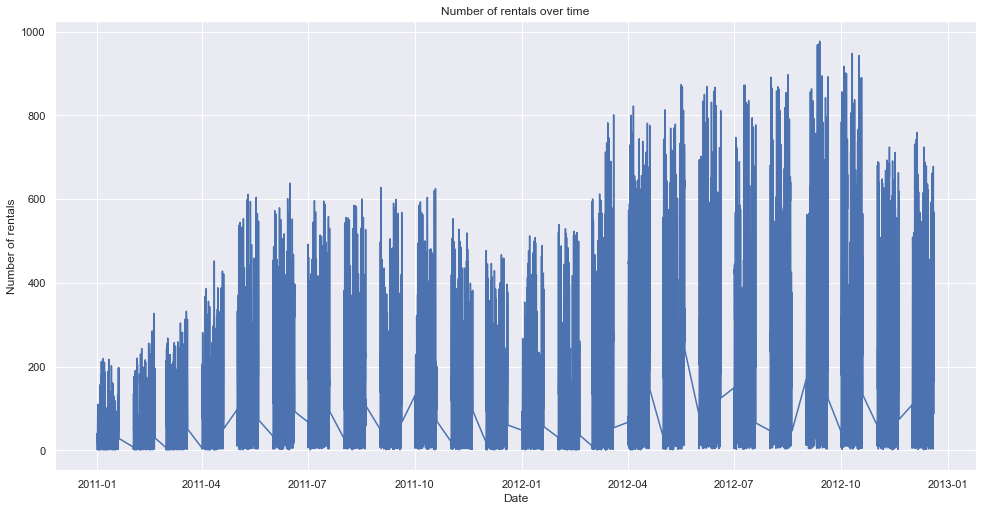

In [12]:
count_time_series = sns.lineplot('datetime-iso8601', 'count', data=train_set_dt)
count_time_series.set(xlabel='Date', ylabel='Number of rentals', title='Number of rentals over time');

Since the start of data collection in January 2011 till the beginning of 2013, the average number of total bike rentals increased 3 fold. It is easy to perceive that the total number of rentals might increase in the future.

### Rentals in each month

In [13]:
train_set_dt['month'] = train_set_dt['datetime-iso8601'].apply(lambda datetime: datetime.strftime('%m')).astype(np.str)

In [14]:
rentals_during_month = pd.DataFrame({
    'Month': train_set_dt['month'],
    'Count': train_set_dt['count'],
    'Casual': train_set_dt['casual'],
    'Registed': train_set_dt['registered']})

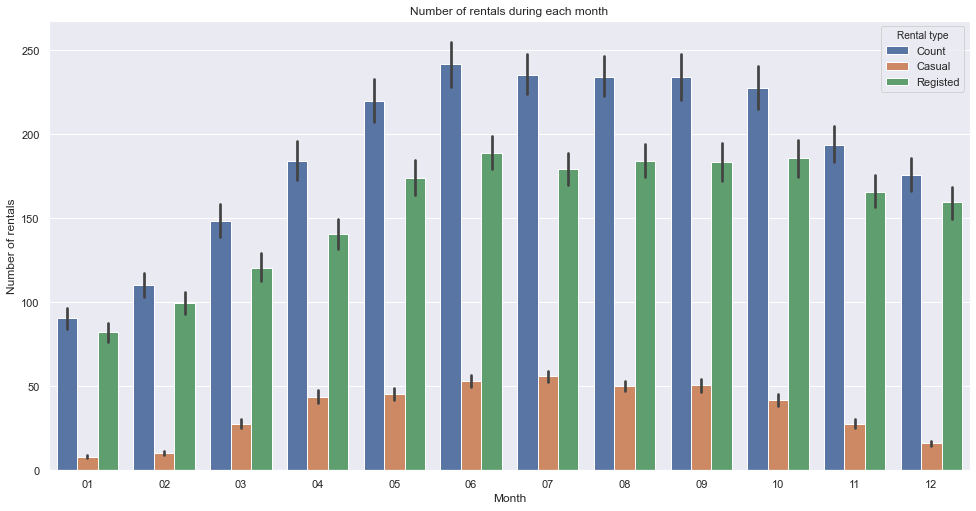

In [15]:
rentals_during_month_plt = sns.barplot(x='Month', y='value', hue='Rental type',
                                      data=pd.melt(rentals_during_month, ['Month'], var_name="Rental type"))
rentals_during_month_plt.set(xlabel='Month', ylabel='Number of rentals', title='Number of rentals during each month');

Barplot of casual and registered number of rentals in each month provides some clarification to previous conclusions regarding bike usage.

Next time, we observe that number of casual rentals is normally distributed with its' peak in June - August. This can mean that not only tourists can make those extra number of casual rentals (it is difficult to conclude this from data), but also that the warmer months encourage people to spontaneously rent a bike.

A number of registered rentals in January - March / early April is significantly lower than in remaining months. It is difficult to conclude why there is such a massive drop of registered users in December - January. One explanation would be weather conditions - although there might be some snow in December in Washington DC, January and February are expected to have the highest snowfall.

### Rentals during week

In [16]:
train_set_dt['weekday'] = train_set_dt['datetime-iso8601'].apply(lambda datetime: datetime.strftime('%A')).astype(np.str)

In [17]:
rentals_during_week = pd.DataFrame({
    'Day': train_set_dt['weekday'],
    'Count': train_set_dt['count'],
    'Casual': train_set_dt['casual'],
    'Registed': train_set_dt['registered']})

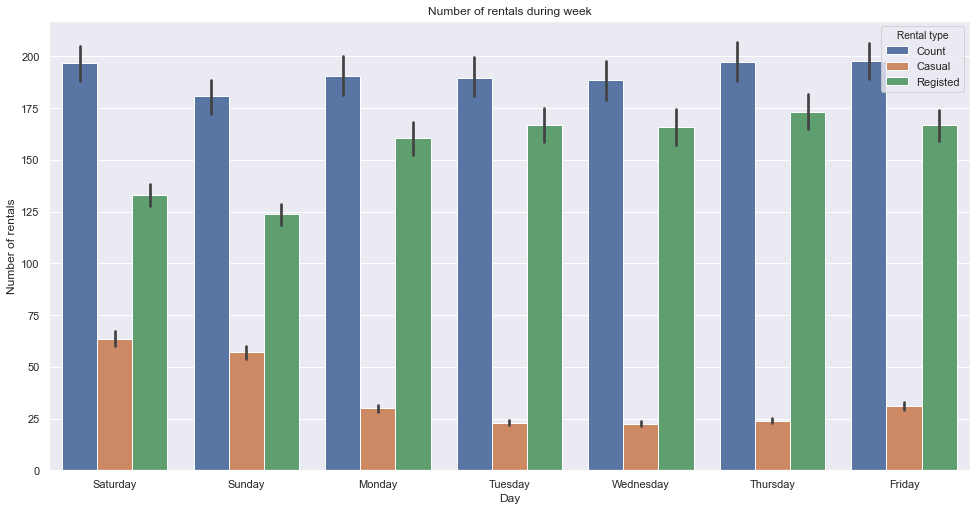

In [18]:
rentals_during_week_plt = sns.barplot(x='Day', y='value', hue='Rental type',
                                      data=pd.melt(rentals_during_week, ['Day'], var_name="Rental type"))
rentals_during_week_plt.set(xlabel='Day', ylabel='Number of rentals', title='Number of rentals during week');

Another intriguing plot is the distribution of all types of rentals across the whole week.

Throughout the weekend the common number of casual rentals is around 60, whereas the same type of rental during the week (except Friday) does not exceed 25.

On the other hand, the number or registered rentals is significantly less during the weekend. Through the week it is approximately 160 rentals per day whereas during the weekend it drops to around 125 rentals.

### Rentals during day

In [19]:
train_set_dt['time'] = train_set_dt['datetime-iso8601'].apply(lambda datetime: datetime.strftime('%H:%M')).astype(np.str)

In [20]:
rentals_during_day = pd.DataFrame({
    'Hour': train_set_dt['time'],
    'Count': train_set_dt['count'],
    'Casual': train_set_dt['casual'],
    'Registed': train_set_dt['registered']})

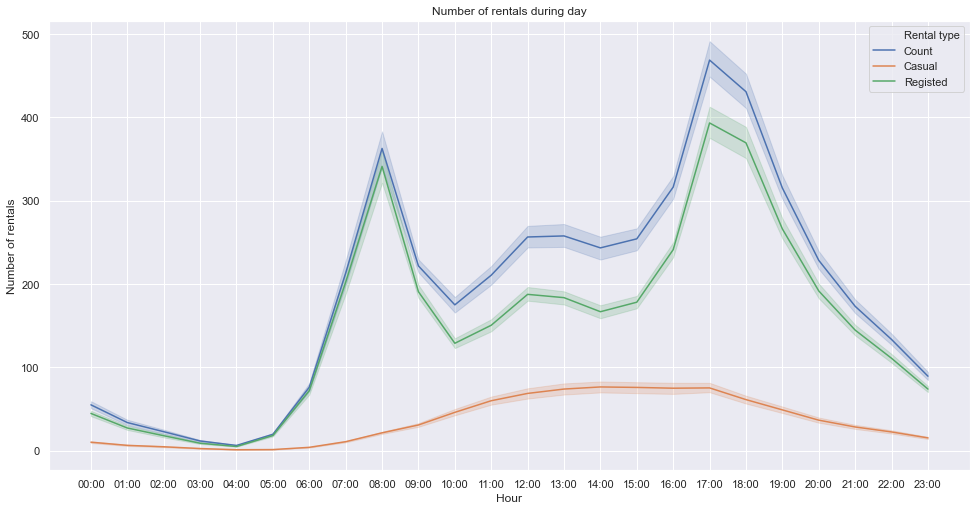

In [21]:
rentals_during_day_plt = sns.lineplot(x='Hour', y='value', hue='Rental type',
                                      data=pd.melt(rentals_during_day, ['Hour'], var_name="Rental type"))
rentals_during_day_plt.set(xlabel='Hour', ylabel='Number of rentals', title='Number of rentals during day');

The chart above shows the number of rentals during the day.

What is probably the most interesting is how different the usage density is for casual and registered rental types.

Registered rentals have two spikes - between 7:00 a.m. and 9:00 a.m. and between 16:30 and 17:30. This means that registered rentals are highly likely to be made by people commuting to and from the workplace or school/university. It can be concluded that registered rentals are made by people that have a pre-defined route that they need to follow daily.

Casual rental distribution is substantially different. It is taking off at around 7:00 a.m. and slowly grows to reach its' peak at around 1 p.m. The plateau lasts till 5 p.m. and then slowly decreases. Casual rentals can be made by tourists as in contract to registered rentals, there are no spikes, but rather normally distributed usage during the day.

### Rentals during workday / weekend

In [22]:
rentals_day_workingday = pd.melt(train_set_dt[['time', 'workingday', 'registered', 'casual']], ['time', 'workingday'],
                                 var_name="Rental type")

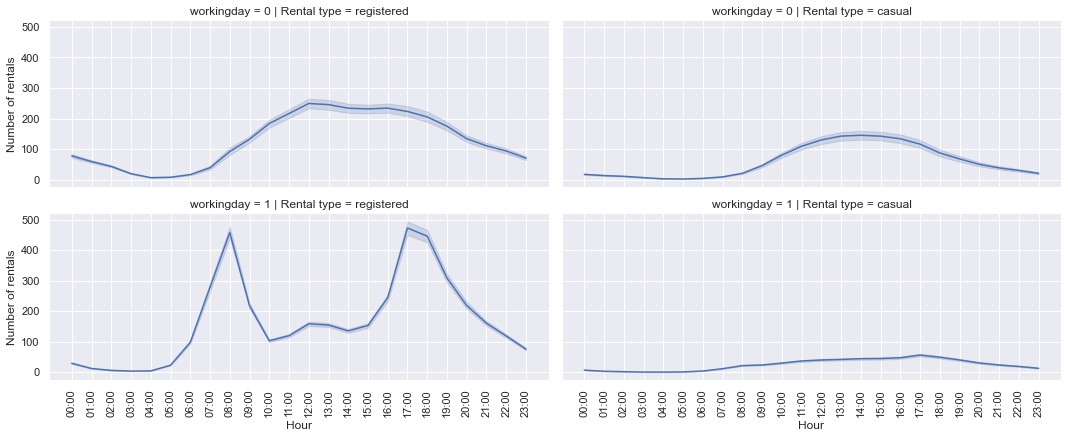

In [23]:
rentals_day_workingday_plt = sns.FacetGrid(data=rentals_day_workingday, col="Rental type", row='workingday', aspect=2.5)
rentals_day_workingday_plt = rentals_day_workingday_plt.map(sns.lineplot, "time", "value")
rentals_day_workingday_plt.set(ylabel='Number of rentals', xlabel='Hour');
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in rentals_day_workingday_plt.axes.flat];

To verify the previous assumptions a facet grid can be created. There are two line plots for different sets of configuration.

People that make registered rentals outside working day still use their bike rental services, but there are no spikes during rush hours. Now the plot is more similar to casual rentals plot - it grows steadily from 8 a.m. reaching plateau level at around 11:00 a.m. It is starting levelling off at around 4 p.m. 

During the peak, there are around 250 rentals during one hour slot and the average number of rentals during the plateau time is about 200.

A total number of casual rentals during the working day is incomparably less than during working days. It stays at a similar level all day reaching less than 80 rentals at its' peak.

### Rentals during holiday

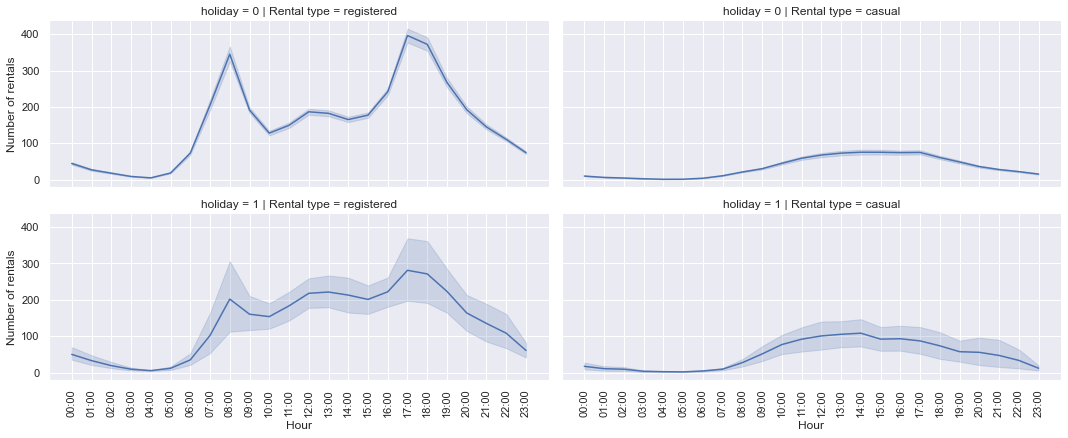

In [24]:
rentals_day_holiday = pd.melt(train_set_dt[['time', 'holiday', 'registered', 'casual']], ['time', 'holiday'],
                              var_name="Rental type")
rentals_day_holiday_plt = sns.FacetGrid(data=rentals_day_holiday, col="Rental type", row='holiday', aspect=2.5)
rentals_day_holiday_plt = rentals_day_holiday_plt.map(sns.lineplot, "time", "value")
rentals_day_holiday_plt.set(ylabel='Number of rentals', xlabel='Hour');
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in rentals_day_holiday_plt.axes.flat];

Analysis of registered and casual rentals during and after a holiday is even more interesting.

The spikes during rush hours are still present for registered rentals - although now the spikes reach 200 and 280 rentals respectively. During working days those were nearly 2.5 times higher. Also, the time between commuting hours shows that the number of registered rentals is much higher than during working days. Now the plateau reaches approximately 220 rentals during a single hour. For working days that figure was close to 140, which is a significant raise.

Number of casual rentals during the holiday is very close to the same type of rental outside holiday time.

The conclusion might be that a significant number of people work during holiday time. On the other hand, casual rentals are mostly done by tourists. For them, it is not as important whether it is a holiday or not and thus a casual number of rentals remain at a similar level throughout the day.

### Pairwise correlation

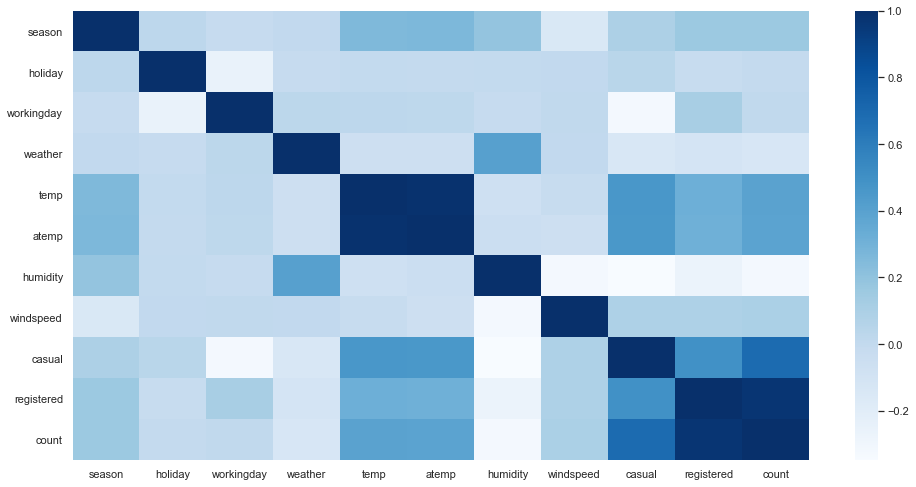

In [25]:
sns.heatmap(train_set_dt.corr(), cmap="Blues");

Pairwise correlation graph shows a linear correlation between two variables.

Some correlations are quite obvious:
* Temperature and 'Feels like' temperature is strongly, linearly correlated
* Casual, registered and total number of rentals are correlated

Few correlations might be a bit more useful:
* Temperature is correlated with a number of all kinds of rentals, although it has a higher impact on casual rentals
* Humidity does not seem to have a significant linear impact on rental demand
* Working-days is affecting registered users, but not that significantly casual users

## Outlier detection

### Count

In [5]:
from scipy.stats import stats

In [6]:
count_z_score = np.abs(stats.zscore(train_set['count']))

In [7]:
print(f"""
Min value: {np.amin(count_z_score)}
Max value: {np.amax(count_z_score)}
""")


Min value: 0.002351094058641562
Max value: 4.3361081667641255



In [8]:
train_set = train_set.drop(*np.where(count_z_score > 3.92))

### Atemp

In [9]:
from scipy.stats import stats

In [10]:
atemp_z_score = np.abs(stats.zscore(train_set['atemp']))

In [11]:
print(f"""
Min value: {np.amin(atemp_z_score)}
Max value: {np.amax(atemp_z_score)}
""")


Min value: 0.01958033240843314
Max value: 2.7009626160291775



In [12]:
train_set = train_set.drop(*np.where(atemp_z_score > 2.6))

### Windspeed

In [17]:
from scipy.stats import stats

In [18]:
windspeed_z_score = np.abs(stats.zscore(train_set['windspeed']))

In [19]:
print(f"""
Min value: {np.amin(windspeed_z_score)}
Max value: {np.amax(windspeed_z_score)}
""")


Min value: 0.02555624332969976
Max value: 4.814825978793148



In [20]:
train_set = train_set.drop(*np.where(windspeed_z_score > 5.1))

## Data preprocessing

### Data cleaning

There are several steps involved in data cleaning phase.

We will convert all columns to numerical format and use one-hot encoding for categorical values.

#### Datetime

First, DateTime column is of type *object* and has to be changed:
* Create column Day
* Create column Month
* Create column Year
* Create column Day of week
* Create column hour
* Delete column DateTime

In [21]:
class DateTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X['iso_datetime'] = pd.to_datetime(X['datetime'])
        X['day'] = X['iso_datetime'].apply(lambda datetime: datetime.strftime('%d')).astype("int")
        X['weekday'] = X['iso_datetime'].apply(lambda datetime: datetime.strftime('%w')).astype("int")
        X['month'] = X['iso_datetime'].apply(lambda datetime: datetime.strftime('%m')).astype("int")
        X['year'] = X['iso_datetime'].apply(lambda datetime: datetime.strftime('%Y')).astype("int")
        X['hour'] = X['iso_datetime'].apply(lambda datetime: datetime.strftime('%H')).astype("int")
        return X

The code is very simple and self-explanatory. First, we create a valid DateTime object out of provided DateTime column and then we create some columns with DateTime properties.

#### Categorical columns

There is a number of ways to convert categorical values into a sparse matrix. SKLearn provides a transformer called OneHotEncoder, nevertheless, it outputs NumPy array instead of Pandas DataFrame.

For this reason, I created a simple wrapper that uses Pandas get_dummies method to create one-hot encoding.

In [22]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin


class OneHotEncoderTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, columns) -> None:
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = pd.get_dummies(X, columns=self.columns)
        return X

#### Column removal

The final class is just a tiny wrapper around Pandas drop method.

Although we can mangle data without those classes, I tend to wrap my core methods within a class as later on, I can use SKlearn pipeline API to clean, prepare and add new features with just one line invocation function.

In [23]:
class LabelRemover(BaseEstimator, TransformerMixin):
    def __init__(self, label):
        self.label = label

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.drop(columns=self.label)

### Feature engineering

The most interesting part of data preparation for many people can be feature engineering.

It takes a lot of creativity to create new features that will actually improve the performance of the ML model.

During the data analysis, we have noticed many correlations and interesting facts from the given dataset. We can use those to create new features.

#### Weekend feature

As the title suggest, Pandas dataframe object can be used to extract day of week from the DateTime object. Based on it, a new column can be added that will check whether the day is either Saturday or Sunday.

In [24]:
class FeatureWeekendTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X['weekend'] = X['iso_datetime'] \
                           .apply(lambda datetime: datetime.strftime('%w')).astype("int") \
                           .apply(lambda datetime: datetime in (0, 6)) * 1
        return X

#### Peak hour feature

From examining the findings of bike usage it is clear that many registered rentals are made to commute to workplace/university etc.
Based on the hour of data it is straightforward to create a boolean feature that will indicate if it is a peak/rush hour or not.

In [25]:
class FeaturePeakHourTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X['peak_hour'] = X['hour'] \
                             .apply(lambda datetime: datetime in (7, 8, 17, 18)) * 1
        return X

#### Is it 2011 feature

Seemingly, this feature might not bring too much benefit, but from the previous analysis, it is clear that there were significantly more rentals in 2012 rather than 2011.

In [26]:
class FeatureIs2011Transformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X['is_2011'] = X['year'] \
                           .apply(lambda datetime: datetime == 2011) * 1
        return X

### Data transformation pipeline

In [27]:
from sklearn.pipeline import Pipeline


one_hot_cols = ['season', 'weather', 'holiday', 'workingday', 'peak_hour', 'weekend', 'is_2011']
prep_pipeline = Pipeline(steps=[
    ('date_transformer', DateTransformer()),
    ('feature_weekend_transformer', FeatureWeekendTransformer()),
    ('feature_peak_hour_transformer', FeaturePeakHourTransformer()),
    ('feature_is_2011_transformer', FeatureIs2011Transformer()),
    ('one_hot_encoder_transformer', OneHotEncoderTransformer(one_hot_cols)),
    ('label_remover', LabelRemover(['iso_datetime', 'datetime']))
])

In [28]:
train_set_prep = prep_pipeline.fit_transform(train_set)
test_set_prep = prep_pipeline.fit_transform(test_set)

In [29]:
train_set_prep.head()

,temp,atemp,humidity,windspeed,casual,registered,count,day,weekday,month,...,holiday_0,holiday_1,workingday_0,workingday_1,peak_hour_0,peak_hour_1,weekend_0,weekend_1,is_2011_0,is_2011_1
0,9.84,14.395,81,0.0,3,13,16,1,6,1,...,1,0,1,0,1,0,0,1,0,1
1,9.02,13.635,80,0.0,8,32,40,1,6,1,...,1,0,1,0,1,0,0,1,0,1
2,9.02,13.635,80,0.0,5,27,32,1,6,1,...,1,0,1,0,1,0,0,1,0,1
3,9.84,14.395,75,0.0,3,10,13,1,6,1,...,1,0,1,0,1,0,0,1,0,1
4,9.84,14.395,75,0.0,0,1,1,1,6,1,...,1,0,1,0,1,0,0,1,0,1


### Train/Test split

In [30]:
from sklearn.model_selection import train_test_split


train_label = train_set['count']
train_set_prep_clean = train_set_prep.drop(columns=['casual', 'registered', 'count'])
X_train, X_test, Y_train, Y_test = train_test_split(train_set_prep_clean, train_label, test_size=0.2, random_state=42)

In [31]:
print(f"""
X_train size: {X_train.shape}
X_test size: {X_test.shape}
Y_train size: {Y_train.shape}
Y_test size: {Y_test.shape}
""")


X_train size: (8699, 27)
X_test size: (2175, 27)
Y_train size: (8699,)
Y_test size: (2175,)



## Models comparison

In [32]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, \
    GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import SGDRegressor


regression_models = {
    'BaggingRegressor': BaggingRegressor(),
    'ExtraTreesRegressor': ExtraTreesRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'RandomForestRegressor': RandomForestRegressor()
}

In [16]:
columns = ['Classifier', 'RMSLE']
df_scores = pd.DataFrame(columns=columns)

In [17]:
from sklearn.metrics import mean_squared_log_error


for name, model in regression_models.items():
    model.fit(X_train, Y_train)
    Y_predicted = model.predict(X_test)
    rmsle = np.sqrt(mean_squared_log_error(Y_test, Y_predicted))
    df_row = pd.DataFrame([[name, rmsle]], columns=columns)
    df_scores = df_scores.append(df_row, ignore_index=True)

In [18]:
df_scores.sort_values(by=['RMSLE'])

,Classifier,RMSLE
1,ExtraTreesRegressor,0.327003
3,RandomForestRegressor,0.330592
0,BaggingRegressor,0.336276
2,KNeighborsRegressor,0.970052


The first three classifiers provide the best RMSLE, those are RandomForestRegressor, ExtraTreesRegressor and BaggingRegressor.

Although default parameters are usually sufficient, those can be tuned to improve the overall score of the model.

## Boosting regressors

In [33]:
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor

regression_models = {
    'AdaBoostRegressor': AdaBoostRegressor(n_estimators=4000, learning_rate=.01),
    'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators=4000, alpha=.01)
}

In [25]:
columns = ['Classifier', 'RMSLE']
df_scores = pd.DataFrame(columns=columns)

In [26]:
from sklearn.metrics import mean_squared_log_error


for name, model in regression_models.items():
    model.fit(X_train, np.log1p(Y_train))
    Y_predicted = model.predict(X_test)
    rmsle = np.sqrt(mean_squared_log_error(Y_test, np.exp(Y_predicted)))
    df_row = pd.DataFrame([[name, rmsle]], columns=columns)
    df_scores = df_scores.append(df_row, ignore_index=True)

In [27]:
df_scores.sort_values(by=['RMSLE'])

,Classifier,RMSLE
1,GradientBoostingRegressor,0.300718
0,AdaBoostRegressor,0.662945


The most promising regressor is GradientBoostingRegressor. It requires further data preprocessing (using log1p function) so the optimizing function can converge, but it achieved a better result than the previous models.

## Hyperparameters tuning

In [36]:
from sklearn.model_selection import GridSearchCV

### RandomForestRegressor

In [37]:
rf_model = RandomForestRegressor()
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'ccp_alpha': [0, .001],
    'oob_score': [True, False],
    'min_impurity_decrease': [0, .001, .01]
}

In [38]:
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_log_error')
rf_grid_search.fit(X_train, Y_train);

In [39]:
rf_grid_search.best_params_

{'ccp_alpha': 0,
 'min_impurity_decrease': 0.001,
 'n_estimators': 300,
 'oob_score': True}

In [42]:
Y_predicted = rf_grid_search.predict(X_test)
np.sqrt(mean_squared_log_error(Y_test, Y_predicted))

0.323842578016515

### GradientBoostingRegressor

In [43]:
gb_model = GradientBoostingRegressor()
gb_param_grid = {
    'n_estimators': [4500, 5000, 5500],
    'alpha': [.01, .02]
}

In [75]:
gb_grid_search = GridSearchCV(estimator=gb_model, param_grid=gb_param_grid, cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error')
gb_grid_search.fit(X_train, np.log1p(Y_train));

In [45]:
gb_grid_search.best_params_

{'alpha': 0.02, 'n_estimators': 5000}

In [46]:
Y_predicted = gb_grid_search.predict(X_test)
np.sqrt(mean_squared_log_error(Y_test, np.exp(Y_predicted)))

0.2987976533500728

### BaggingRegressor

In [47]:
br_model = BaggingRegressor()
br_param_grid = {
    'n_estimators': [10, 100, 200],
    'max_features': [.7, .8, .9, 1],
    'oob_score': [True, False]
}

In [48]:
br_grid_search = GridSearchCV(estimator=br_model, param_grid=br_param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_log_error')
br_grid_search.fit(X_train, Y_train);

In [51]:
br_grid_search.best_params_

{'max_features': 0.9, 'n_estimators': 100, 'oob_score': True}

In [52]:
Y_predicted = br_grid_search.predict(X_test)
np.sqrt(mean_squared_log_error(Y_test, Y_predicted))

0.410728583399871

## Learning curve 

In [55]:
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import LearningCurve

### RandomForestRegressor

In [56]:
rf_model = RandomForestRegressor(**rf_grid_search.best_params_)

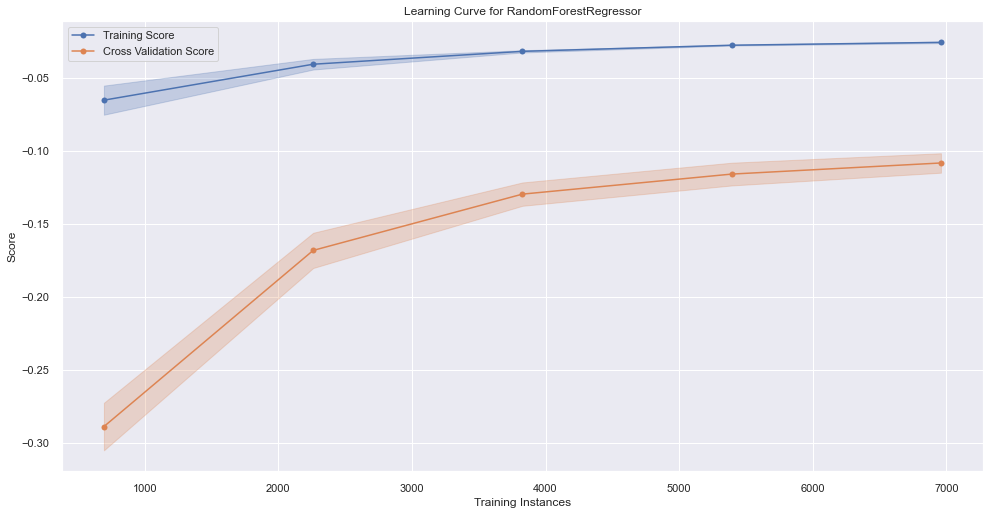

In [57]:
visualizer = LearningCurve(rf_model, scoring='neg_mean_squared_log_error')
visualizer.fit(X_train, Y_train)
visualizer.show();

### GradientBoostingRegressor

In [58]:
gb_model = GradientBoostingRegressor(**gb_grid_search.best_params_)

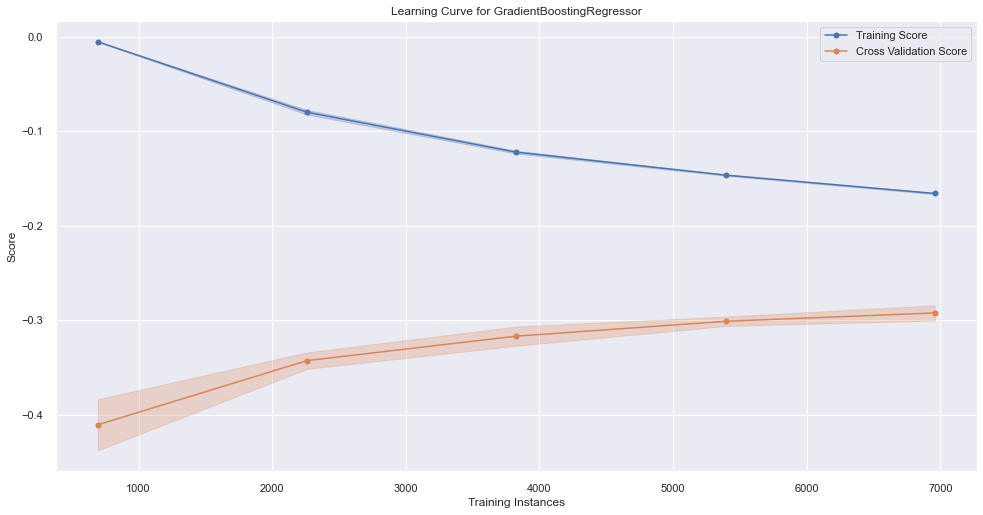

In [76]:
visualizer = LearningCurve(gb_model, scoring='neg_root_mean_squared_error')
visualizer.fit(X_train, np.log1p(Y_train))
visualizer.show();

### BaggingRegressor

In [61]:
br_model = BaggingRegressor(**br_grid_search.best_params_)

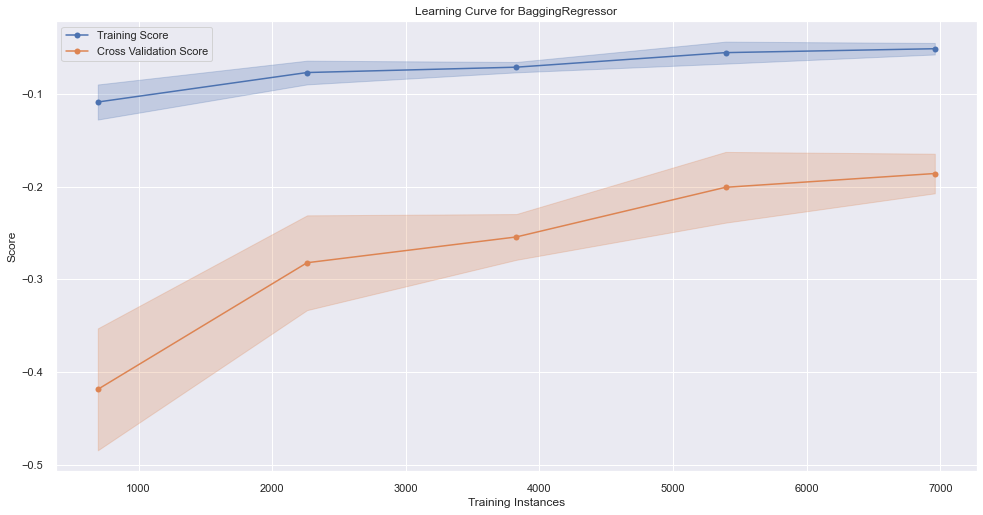

In [62]:
visualizer = LearningCurve(br_model, scoring='neg_mean_squared_log_error')
visualizer.fit(X_train, Y_train)
visualizer.show();

The above plots show cross-validation score in each Nth training instance along with the training score.

As might be seen in the above plots, the model is far from being perfect. It converges in about 5000 training instances reaching plateau thereafter.

Adding more training data is unlikely to help as the function is not converging noticeably after 6000 training instances.

All regressor models seem to have similar performance over time.

## Ensemble methods

Another way to improve the score of the model is by using ensemble methods.

Simply put, all three previous models can be combined and use 'voting' to predict the most probable outcome (an outcome that is the most confident by any of the learning models).

In [63]:
from sklearn.ensemble import VotingRegressor

In [64]:
regressors = [
    ('RandomForestRegressor', rf_model),
    ('BaggingRegressor', br_model)
]
voting_reg = VotingRegressor(regressors)

In [ ]:
voting_reg.fit(X_train, Y_train);

In [66]:
Y_predicted = voting_reg.predict(X_test)
np.sqrt(mean_squared_log_error(Y_test, Y_predicted))

0.3857414650687495

The performance is slightly worse than GradientBoostingRegressor, hence the latter will be used for submission.

## Submission

With all data prepared and machine learning model fitted, prediction can be saved to CSV file.

In [68]:
gb_model = GradientBoostingRegressor(**gb_grid_search.best_params_)
test_Y_final = gb_model.predict(test_set_prep)

In [69]:
predicted_count = pd.DataFrame({
    'datetime': test_set['datetime'],
    'count': np.exp(test_Y_final)
})

In [70]:
predicted_count.to_csv(index=False, path_or_buf='./submission.csv')